Fitting 5 folds for each of 29160 candidates, totalling 145800 fits
[0]	validation_0-logloss:0.62935
[1]	validation_0-logloss:0.61868
[2]	validation_0-logloss:0.61087
[3]	validation_0-logloss:0.60090
[4]	validation_0-logloss:0.59179
[5]	validation_0-logloss:0.58712
[6]	validation_0-logloss:0.58227
[7]	validation_0-logloss:0.58067
[8]	validation_0-logloss:0.57509
[9]	validation_0-logloss:0.56965
[10]	validation_0-logloss:0.56847
[11]	validation_0-logloss:0.56343
[12]	validation_0-logloss:0.55576
[13]	validation_0-logloss:0.55521
[14]	validation_0-logloss:0.55188
[15]	validation_0-logloss:0.54716
[16]	validation_0-logloss:0.54065
[17]	validation_0-logloss:0.53503
[18]	validation_0-logloss:0.53209
[19]	validation_0-logloss:0.52955
[20]	validation_0-logloss:0.52432
[21]	validation_0-logloss:0.52180
[22]	validation_0-logloss:0.51398
[23]	validation_0-logloss:0.50894
[24]	validation_0-logloss:0.50636
[25]	validation_0-logloss:0.50734
[26]	validation_0-logloss:0.50445
[27]	validation_0-loglos

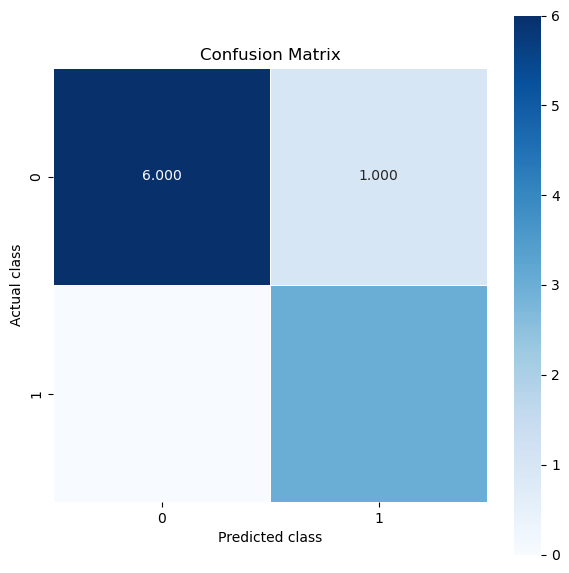

KeyError: 'train'

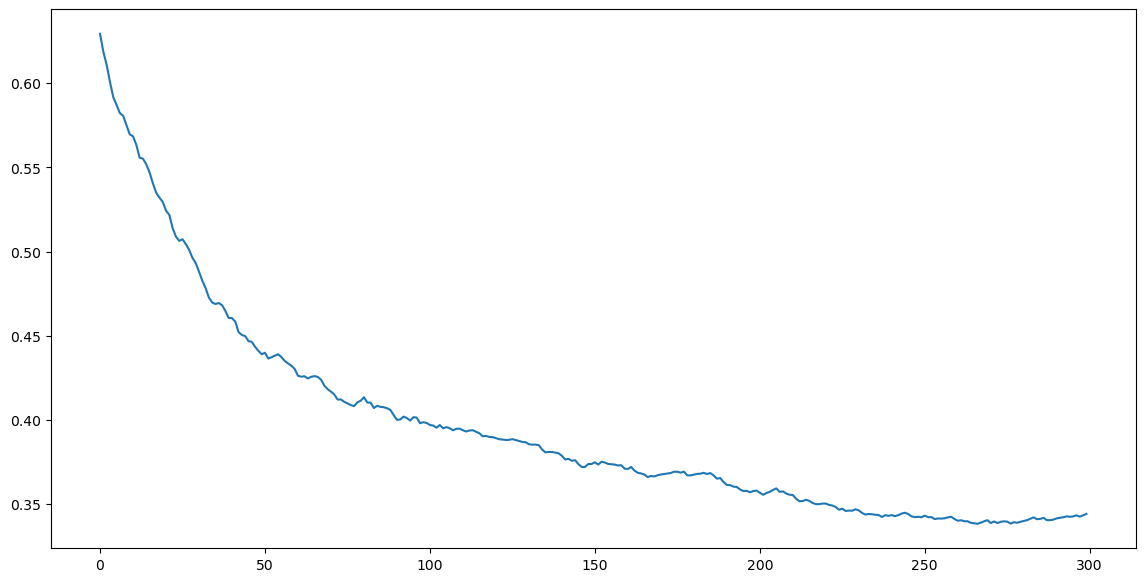

In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 데이터 불러오기
df = pd.read_excel('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min3.xlsx')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 2, 3, 5, 10],
    'reg_alpha': [0, 1, 2, 3, 4, 5]
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Grid Search 초기화
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
grid_search.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True)
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 학습 데이터 성능
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
train_f1 = f1_score(y_train, best_model.predict(X_train))
train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])

print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Training ROC AUC: {train_roc_auc:.4f}')

# 검증 데이터 성능
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, y_pred_best)
valid_f1 = f1_score(y_valid, y_pred_best)
valid_roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f'Validation accuracy: {valid_accuracy:.4f}')
print(f'Validation F1 Score: {valid_f1:.4f}')
print(f'Validation ROC AUC: {valid_roc_auc:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.plot(x_axis, evals_result['train']['logloss'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 데이터 불러오기
df = pd.read_excel('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min3.xlsx')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [1, 2, 3],
    'reg_alpha': [0, 1, 2]
}

# 사용자 정의 XGBoost 모델 초기화
class CustomXGBoostClassifier(xgb.XGBClassifier):
    def fit(self, X, y, eval_set=None, early_stopping_rounds=None, **fit_params):
        if eval_set and early_stopping_rounds:
            return super().fit(X, y, eval_set=eval_set, early_stopping_rounds=early_stopping_rounds, **fit_params)
        else:
            return super().fit(X, y, **fit_params)

model = CustomXGBoostClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Grid Search 초기화
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,         # 3겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
grid_search.fit(
    X_train, y_train, 
    eval_set=[(X_valid, y_valid)], 
    early_stopping_rounds=10,  # early_stopping_rounds 설정
    verbose=True
)
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 학습 데이터 성능
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
train_f1 = f1_score(y_train, best_model.predict(X_train))
train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])

print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Training ROC AUC: {train_roc_auc:.4f}')

# 검증 데이터 성능
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, y_pred_best)
valid_f1 = f1_score(y_valid, y_pred_best)
valid_roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f'Validation accuracy: {valid_accuracy:.4f}')
print(f'Validation F1 Score: {valid_f1:.4f}')
print(f'Validation ROC AUC: {valid_roc_auc:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()


In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 데이터 불러오기
df = pd.read_excel('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min3.xlsx')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']
print("Before conversion: ", y.dtypes, y.unique())

# 타겟 변수를 정수형으로 변환
y = y.astype(int)
print("After conversion: ", y.dtypes, y.unique())

X = df.drop(columns=['blueWins', 'gameId'])  # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 2, 3, 5, 10],
    'reg_alpha': [0, 1, 2, 3, 4, 5]
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Grid Search 초기화
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
grid_search.fit(X_train, y_train, eval_set=[(X_train, 'train'), (X_valid, 'validation')], verbose=True)
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 학습 데이터 성능
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
train_f1 = f1_score(y_train, best_model.predict(X_train))
train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])

print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Training ROC AUC: {train_roc_auc:.4f}')

# 검증 데이터 성능
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, y_pred_best)
valid_f1 = f1_score(y_valid, y_pred_best)
valid_roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f'Validation accuracy: {valid_accuracy:.4f}')
print(f'Validation F1 Score: {valid_f1:.4f}')
print(f'Validation ROC AUC: {valid_roc_auc:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_1']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_1']['logloss'], label='Validation')
plt.plot(x_axis, evals_result['train']['logloss'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Before conversion:  int64 [0 1]
After conversion:  int32 [0 1]
Fitting 3 folds for each of 29160 candidates, totalling 87480 fits


ValueError: 
All the 87480 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
87480 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py", line 1500, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py", line 572, in _wrap_evaluation_matrices
    m = create_dmatrix(
        ^^^^^^^^^^^^^^^
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py", line 963, in _create_dmatrix
    return DMatrix(**kwargs, nthread=self.n_jobs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\core.py", line 869, in __init__
    self.set_info(
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\core.py", line 932, in set_info
    self.set_label(label)
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\core.py", line 1070, in set_label
    dispatch_meta_backend(self, label, "label", "float")
  File "c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\data.py", line 1257, in dispatch_meta_backend
    raise TypeError("Unsupported type for " + name, str(type(data)))
TypeError: ('Unsupported type for label', "<class 'str'>")


Fitting 5 folds for each of 29160 candidates, totalling 145800 fits
[0]	validation_0-logloss:0.60794
[1]	validation_0-logloss:0.61085
[2]	validation_0-logloss:0.61377
[3]	validation_0-logloss:0.60878
[4]	validation_0-logloss:0.60386
[5]	validation_0-logloss:0.60671
[6]	validation_0-logloss:0.60958
[7]	validation_0-logloss:0.61245
[8]	validation_0-logloss:0.61533
[9]	validation_0-logloss:0.61052
[10]	validation_0-logloss:0.61337
[11]	validation_0-logloss:0.61623
[12]	validation_0-logloss:0.61911
[13]	validation_0-logloss:0.62199
[14]	validation_0-logloss:0.62487
[15]	validation_0-logloss:0.62777
[16]	validation_0-logloss:0.63067
[17]	validation_0-logloss:0.63357
[18]	validation_0-logloss:0.63649
[19]	validation_0-logloss:0.63940
[20]	validation_0-logloss:0.64233
[21]	validation_0-logloss:0.63770
[22]	validation_0-logloss:0.64060
[23]	validation_0-logloss:0.64351
[24]	validation_0-logloss:0.64642
[25]	validation_0-logloss:0.64933
[26]	validation_0-logloss:0.65225
[27]	validation_0-loglos

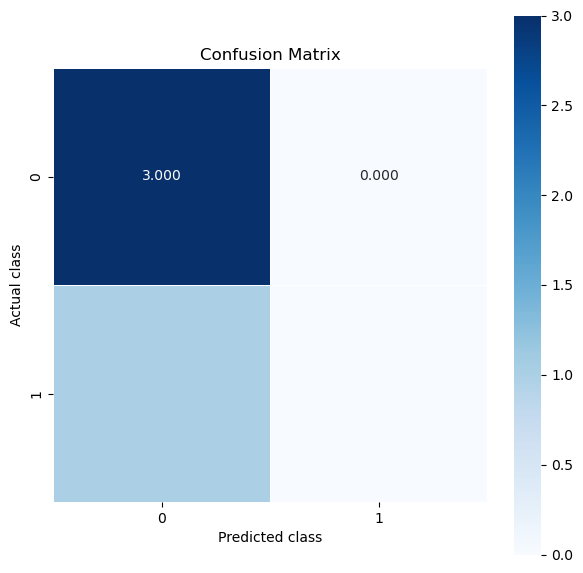

KeyError: 'train'

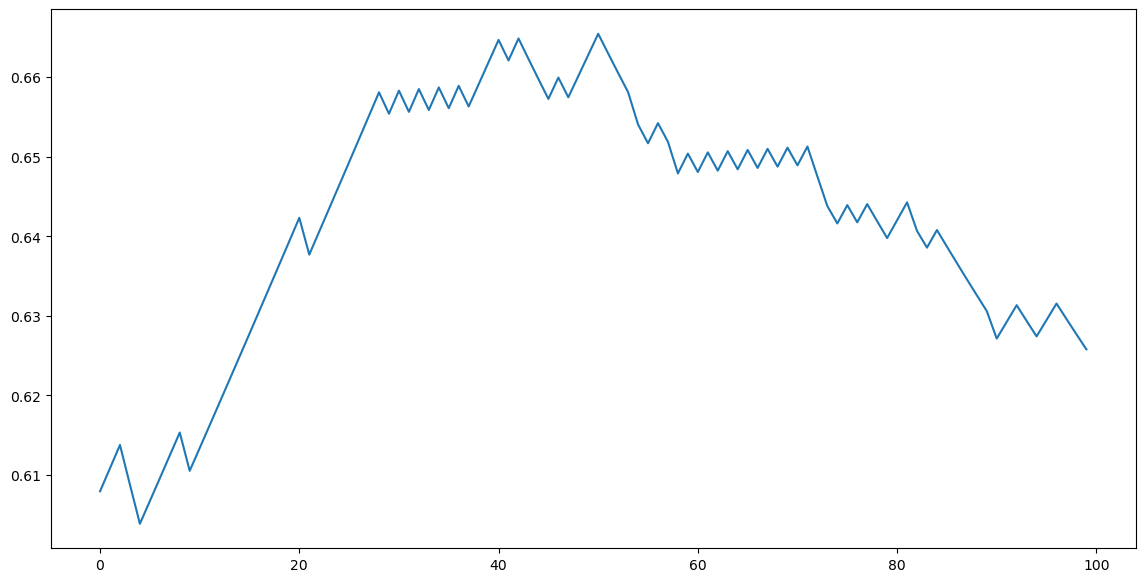

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 데이터 불러오기
df = pd.read_excel('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min4.xlsx')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 2, 3, 5, 10],
    'reg_alpha': [0, 1, 2, 3, 4, 5]
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Grid Search 초기화
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
grid_search.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True)
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 학습 데이터 성능
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
train_f1 = f1_score(y_train, best_model.predict(X_train))
train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])

print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Training ROC AUC: {train_roc_auc:.4f}')

# 검증 데이터 성능
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, y_pred_best)
valid_f1 = f1_score(y_valid, y_pred_best)
valid_roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f'Validation accuracy: {valid_accuracy:.4f}')
print(f'Validation F1 Score: {valid_f1:.4f}')
print(f'Validation ROC AUC: {valid_roc_auc:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.plot(x_axis, evals_result['train']['logloss'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Before conversion:  int64 [0 1]
After conversion:  int32 [0 1]
Fitting 3 folds for each of 29160 candidates, totalling 87480 fits
[0]	validation_0-logloss:0.66815	validation_1-logloss:0.60794
[1]	validation_0-logloss:0.66334	validation_1-logloss:0.61085
[2]	validation_0-logloss:0.65860	validation_1-logloss:0.60585
[3]	validation_0-logloss:0.65392	validation_1-logloss:0.60091
[4]	validation_0-logloss:0.64930	validation_1-logloss:0.59603
[5]	validation_0-logloss:0.64473	validation_1-logloss:0.59121
[6]	validation_0-logloss:0.64052	validation_1-logloss:0.58887
[7]	validation_0-logloss:0.63605	validation_1-logloss:0.59161
[8]	validation_0-logloss:0.63164	validation_1-logloss:0.58688
[9]	validation_0-logloss:0.62729	validation_1-logloss:0.58221
[10]	validation_0-logloss:0.62298	validation_1-logloss:0.58489
[11]	validation_0-logloss:0.61874	validation_1-logloss:0.58029
[12]	validation_0-logloss:0.61454	validation_1-logloss:0.57574
[13]	validation_0-logloss:0.61040	validation_1-logloss:0.5712

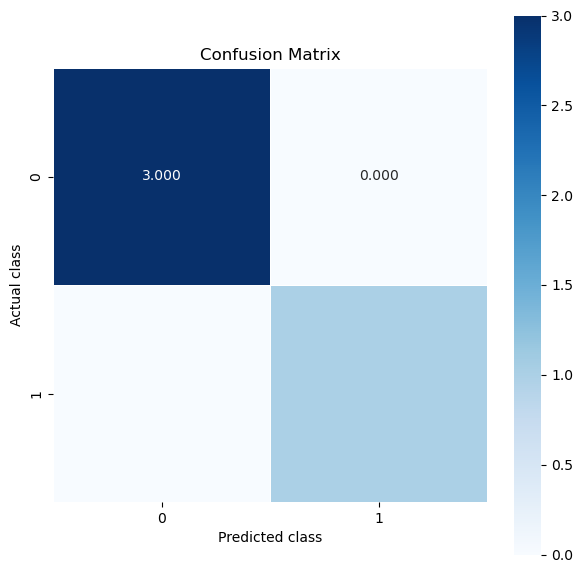

KeyError: 'train'

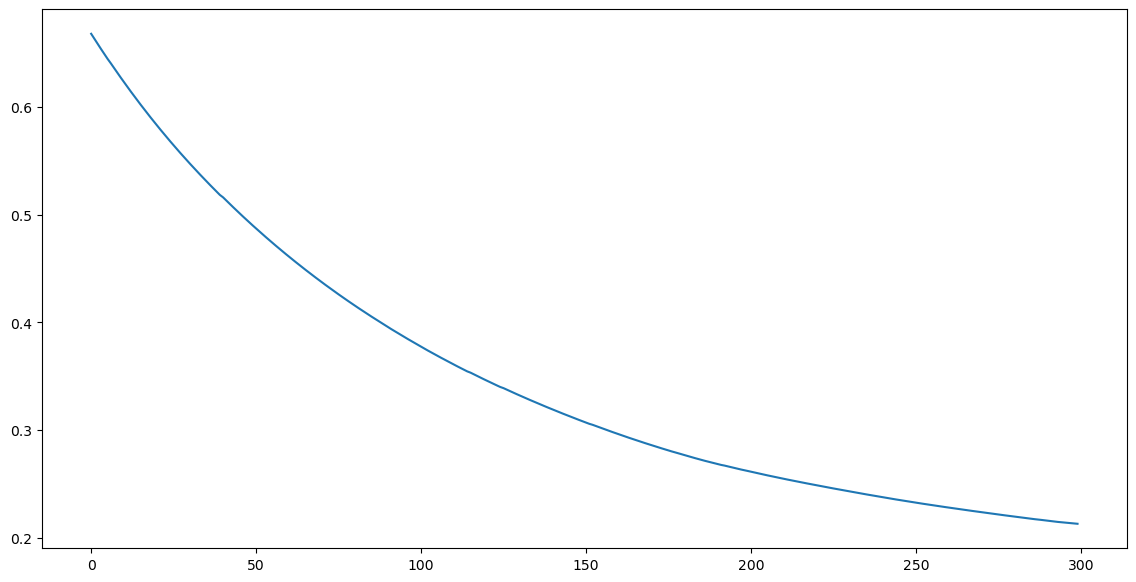

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 데이터 불러오기
df = pd.read_excel('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min4.xlsx')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# y 변수 데이터 타입 확인 및 변환
print("Before conversion: ", y.dtypes, y.unique())
y = y.astype(int)
print("After conversion: ", y.dtypes, y.unique())

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 2, 3, 5, 10],
    'reg_alpha': [0, 1, 2, 3, 4, 5]
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Grid Search 초기화
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=True)
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 학습 데이터 성능
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
train_f1 = f1_score(y_train, best_model.predict(X_train))
train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])

print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Training F1 Score: {train_f1:.4f}')
print(f'Training ROC AUC: {train_roc_auc:.4f}')

# 검증 데이터 성능
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, y_pred_best)
valid_f1 = f1_score(y_valid, y_pred_best)
valid_roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f'Validation accuracy: {valid_accuracy:.4f}')
print(f'Validation F1 Score: {valid_f1:.4f}')
print(f'Validation ROC AUC: {valid_roc_auc:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.plot(x_axis, evals_result['train']['logloss'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()
